# Анализ исторических данных о продажах игр, оценок пользователей и экспертов, жанров и платформ для выявления потенциально популярного продукта и планирования рекламных кампаний на следующий год.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

<b>Описание данных:</b>
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.<br/><br/>
Данные за 2016 год могут быть неполными.

##  Открываем файл с данными и изучаем общую информацию.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# Открытие файла
df = pd.read_csv('datasets/games.csv')

#Смотрим общую информаию
df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [2]:
# Посмотрим на пропуски
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [3]:
# Проверим наличие полных дубликатов
df.duplicated().sum()

0

По общей информации видно, что:
- Нужно привести столбецы Year_of_Release и User_Score к нужному типу.
- Столбцы привести к нижнему регистру.
- Попытаться понять причину пропусков и обработать их.

## Подготовка данных.

In [4]:
# Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [5]:
# Пропуски в name и genre заменим на пустую строку 
df.fillna({'name':" ",'genre': " "}, inplace=True)
# Обнаруженные в столбце user_score значения "tbd" заменим на NaN
df.query('user_score == "tbd"')
df['user_score'] = df['user_score'].replace("tbd", np.NaN)
# Пропуски в графе rating заменим на unknown
df['rating'] = df['rating'].fillna('unknown')

Пропуски в name и genre заменили на пустую строчку, потому что нас в первую очередь интересуют финансовые показатели, а не название игры. Аббревиатура 'tbd' расшифровывается - To Be Determined, то есть "Будет определено". Когда данные готовятся, но пока ещё нет возможности назвать точную оценку, именно это сокращение и используется. 'tbd' заменил на NaN для возможности дальнейших вычислений.<br/>
Пропуски в critic_score и user_score не буду трогать во-первых по причине того, что много пропусков у старых до 1994г т.к еще не было организацый или сайтов которые бы выставляли рейтинги играм, во-вторых оценка игры это уникальное значение которое не заполнить средним или медианным - все игры уникальны и оценка соответственно то же.<br/>
Пропуски в rating заполнил маркером "unknown", чтобы не потерять большой объем данных и в портрете пользователя увидеть объем продаж, который был осуществлен по видеоиграм без определенного рейтинга.

In [6]:
# Преобразование данных в нужные типы
df['year_of_release'] = df['year_of_release'].astype('Int64')
df['user_score'] = df['user_score'].astype(float)
df.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

Тип в year_of_release меняем с float на int. Не нужны нам дроби в годах.<br/>
Тип в user_score меняем с object в float. Оценки должны быть в численном формате.

In [7]:
# Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


## Исследовательский анализ данных.

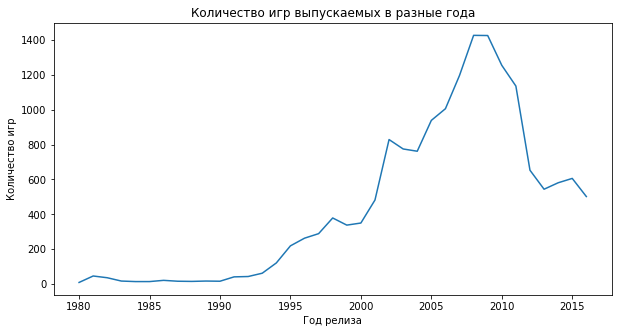

In [8]:
# Cколько игр выпускалось в разные годы
games_on_year = df.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(10,5))
sns.lineplot(data=games_on_year)
plt.title('Количество игр выпускаемых в разные года')
plt.xlabel('Год релиза')
plt.ylabel('Количество игр')
plt.legend([], frameon=False)
plt.show()

До 1994 года игровая индустрия явно топталась на одном месте, но после с развитием програмного и аппаратного обеспечений, а так же интернета произошел бурный рост рынка. С 2009 года наблюдаем снижение количества выпускаемых игр. Это напрямую связано с параллельным развитием более перспективного рынка мобильного гейминга.

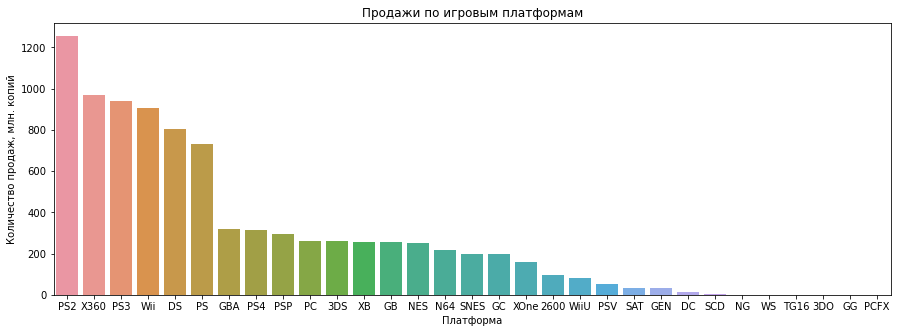

In [9]:
# Выбераем платформы с наибольшими суммарными продажами
sales_on_platform = df.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False)
plt.figure(figsize=(15,5))
sns.barplot(data=sales_on_platform, x=sales_on_platform.index, y='total_sales')
plt.title('Продажи по игровым платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество продаж, млн. копий')
plt.show()

Из графика видно, что больше всего продаж у PS2, X360, PS3, Wii, DS и PS.

In [10]:
# Выделим 6 самых продаваемых платформ
top6 = df.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False).head(6)
top6

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86


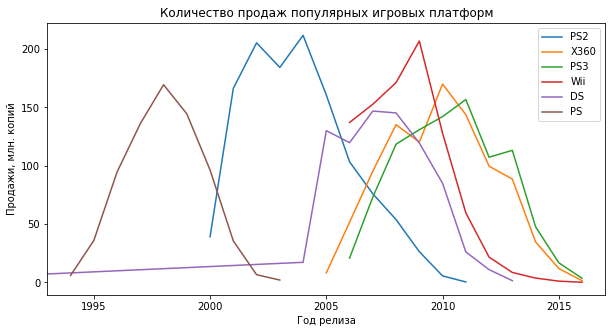

In [11]:
# Напишем функцию которая будет выводить сводную таблицу по продажам отдельной платформы
def platform_sale(name, data):
    platform = data[data['platform'] == name]
    total = platform.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    return total

# Построем распределение по годам для 6 самых успешных платформ
plt.figure(figsize=(10,5))
plt.title('Количество продаж популярных игровых платформ')
plt.xlabel('Год релиза')
plt.ylabel('Продажи, млн. копий')
plt.xlim(1993,2017)

for platform in top6.index:
    sns.lineplot(data=platform_sale(platform,df)['total_sales'], label=platform)
    plt.legend()

Можно из графика заметить, что каждая из платформ в среднем приносила доход 10 лет
- PlayStation - 9 лет (c 1994 по 2003)
- PlayStation 2 - 11 лет (с 2000 по 2011)
- Nintendo DS - 9 лет (c 2004 по 2013)
- Xbox 360 - 11 лет (с 2005 по 2016)
- PlayStation 3 - 10 лет (c 2006 по 2016)
- Nintendo Wii - 10 лет (c 2006 по 2016)

Актуальными данными для своего исследования буду считать с 2013 года. Этот год можно считать перломным, для коррекции рынка начиная с 2009. И это произошло не без участия главных гигантов консольного рынка PlayStation и Xbox. В 2013 году вышли PlayStation 4 и Xbox One. И началась смена поколений на консольном рынке.

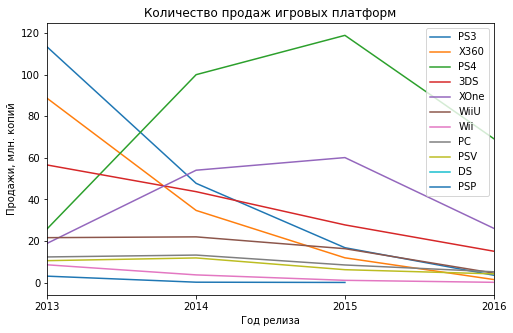

In [12]:
# Обновляем таблицу по актуальным данным
df_actual = df[df['year_of_release']>=2013]

# Строим график по продажам за актуальный период
plt.figure(figsize=(8,5))
plt.title('Количество продаж игровых платформ')
plt.xlabel('Год релиза')
plt.ylabel('Продажи, млн. копий')
plt.xlim(2013,2016)
plt.xticks(range(2013, 2017))  
for platform in df_actual['platform'].unique():
    sns.lineplot(data=platform_sale(platform,df_actual)['total_sales'], label=platform)
    plt.legend()

Из графика видно, что продажи по всем платформам падают, рынок мобильных игр безжалостен. Но на плаву и в топе по продажам остаются PlayStation 4, Xbox One и Nintendo 3DS. По всем остальным платформам продажи одинаково малы.

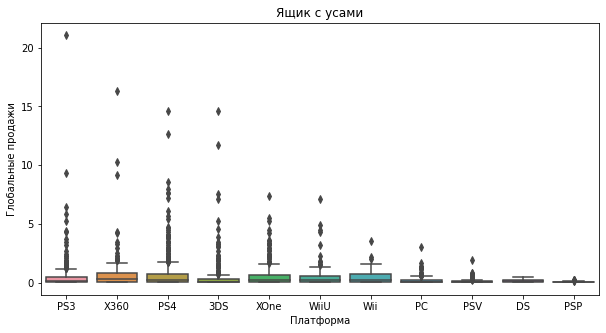

In [13]:
# Построем график «ящик с усами» по глобальным продажам игр в разбивке по платформам
plt.figure(figsize=(10,5))
sns.boxplot(data=df_actual, x='platform', y='total_sales')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')
plt.title('Ящик с усами')
plt.show()

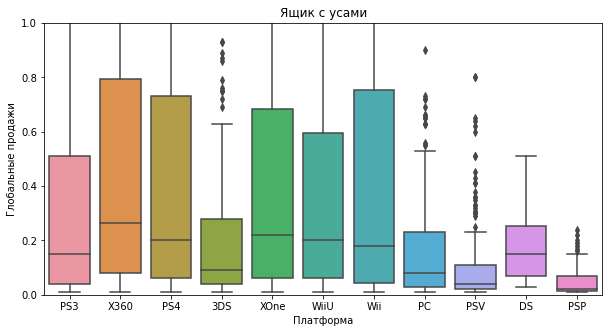

In [14]:
# В приближении
plt.figure(figsize=(10,5))
sns.boxplot(data=df_actual, x='platform', y='total_sales')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')
plt.title('Ящик с усами')
plt.ylim(0,1)
plt.show()

Из графиков можно сделать выводы:
- Самые большие медианные продажи у X360. Следом идут XOne, WiiU, PS4, Wii и PS3.
- Практически все консоли имеют много выбросов. Это очень упешные игры, которые принесли большое количество продаж.

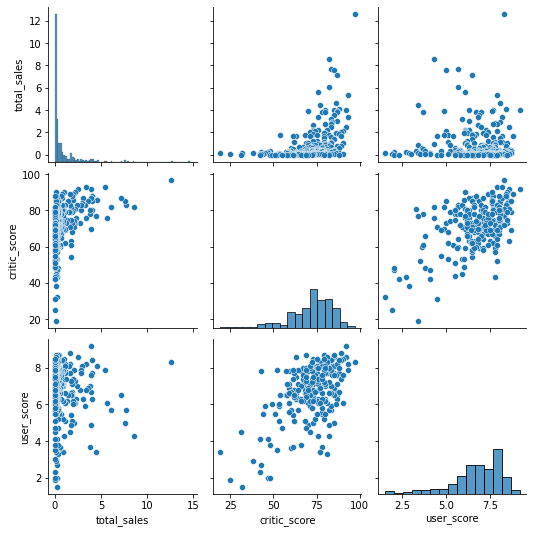

In [15]:
# Посмотрим как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков
ps4 = df_actual[df_actual['platform'] == "PS4"][['total_sales', 'critic_score', 'user_score']]
sns.pairplot(ps4)
plt.show()

На графике видно, что чем выше оценки критиков, тем больше продажи у игры.<br/>
С оценками игроков не все однозначно. Есть игры с плохими оценками, но с довольно внушительными продажами.<br/>
Это может быть связано и неоправданными ожиданиями игроков относилеьно новой части игры популярной серии, а так же специальным занижением рейтинга игры в рамках протеста против компании-разработчика.

In [16]:
# Посмотрим корреляцию между отцывами и продажами
ps4.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


Между оценками критиков и продажами есть умеренная прямая зависимость, а вот между оценками игроков и продажами корреляция у нуля. Эти данные подтверждают предыдущие выводы по матрицы диаграммы рассеяния.

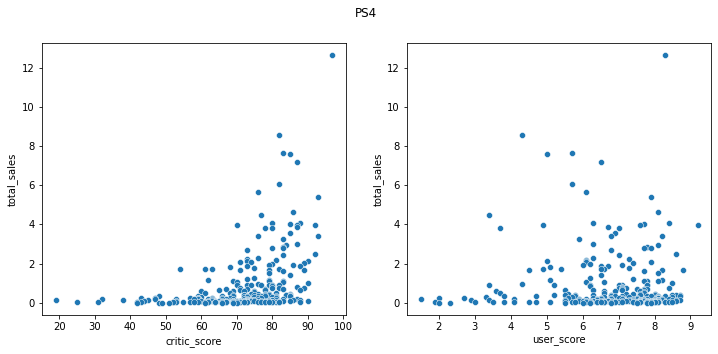

Корреляция между отзывами крититков и продажами: 0.40656790206178095
Корреляция между отзывами пользователей и продажами: -0.031957110204556424


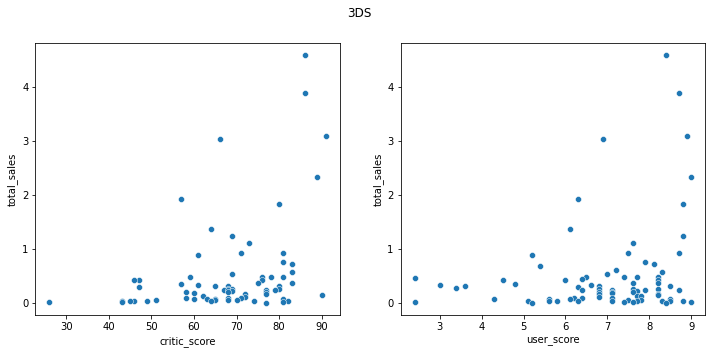

Корреляция между отзывами крититков и продажами: 0.3570566142288103
Корреляция между отзывами пользователей и продажами: 0.24150411773563016


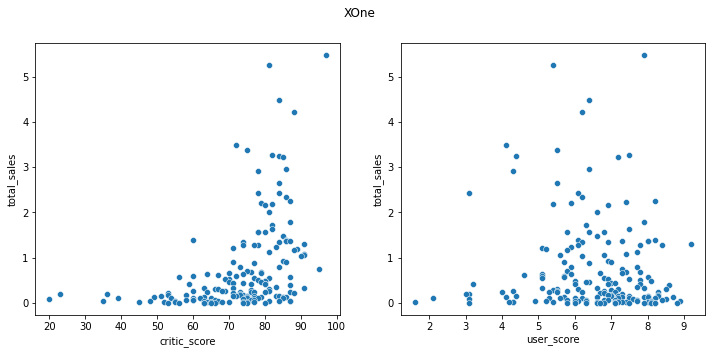

Корреляция между отзывами крититков и продажами: 0.4169983280084017
Корреляция между отзывами пользователей и продажами: -0.06892505328279414


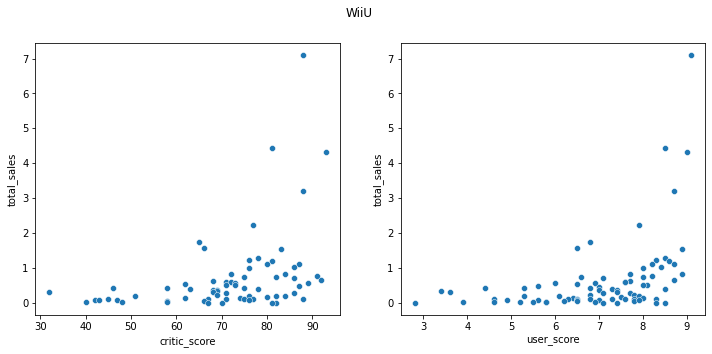

Корреляция между отзывами крититков и продажами: 0.3764149065423912
Корреляция между отзывами пользователей и продажами: 0.4193304819266187


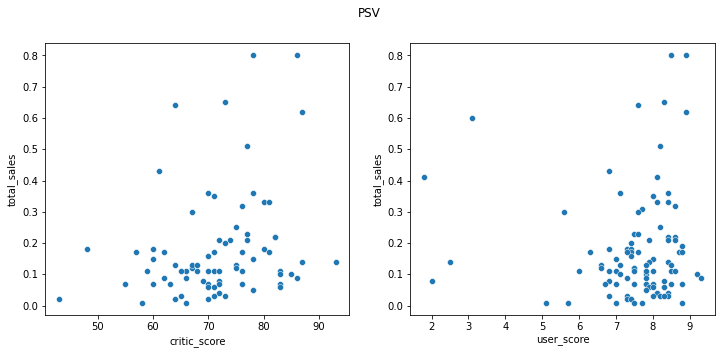

Корреляция между отзывами крититков и продажами: 0.2547423503068656
Корреляция между отзывами пользователей и продажами: 0.0009424723319108626


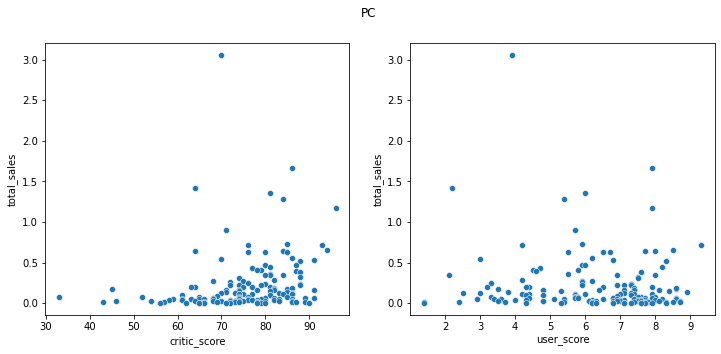

Корреляция между отзывами крититков и продажами: 0.19603028294369382
Корреляция между отзывами пользователей и продажами: -0.0938418695247674


In [17]:
# Соотнесем выводы с продажами игр на других платформах
# Добавим в список 3DS, XOne как самые продаваемые в 2016г
# а так же WiiU c PSV как консоли восьмого поколения
# И добавим туда PC - персональные компьютеры
list_top = ['PS4', '3DS', 'XOne', 'WiiU', 'PSV', 'PC']

# Функция, которая будет отрисовывать графики рассеивания и считать корреляции
def other_platform(name):
    platform = df_actual[df_actual['platform']==name]
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sns.scatterplot(x='critic_score', y='total_sales', data=platform, ax=ax[0])
    sns.scatterplot(x='user_score', y='total_sales', data=platform, ax=ax[1])
    fig.suptitle(name)
    plt.show()
    
    critic_correl = platform['critic_score'].corr(platform['total_sales'])
    user_correl = platform['user_score'].corr(platform['total_sales'])
    print('Корреляция между отзывами крититков и продажами:', critic_correl)
    print('Корреляция между отзывами пользователей и продажами:',user_correl)
    
for platform in list_top:
    other_platform(platform)

XOne имеет практически идентичные корреляции с PS4.<br/>
У PSV и PC корреляция между отзывами крититков и продажами, хоть и есть, но уже слабее чем у PS4 и XOne.<br/>
У 3DS на удивление появляется слабая корреляция между отзывами пользователей и продажами.<br/>
А WiiU единственная у которой кореляция между отзывами пользователей и продажами больше чем корреляция между отзывами крититков и продажами.<br/><br/>

По итогу можно сказать:
- Перед покупкой люди прислушиваются в той или иной степени к мнению критиков и это относится ко всем платформам.
- На японском рынке где преобладает Nintendo, люди прислушиваются и к другим пользователям. Это может являться частью менталитета или популярностью какого-либо интернет ресурса с рейтингами игр от пользователей.

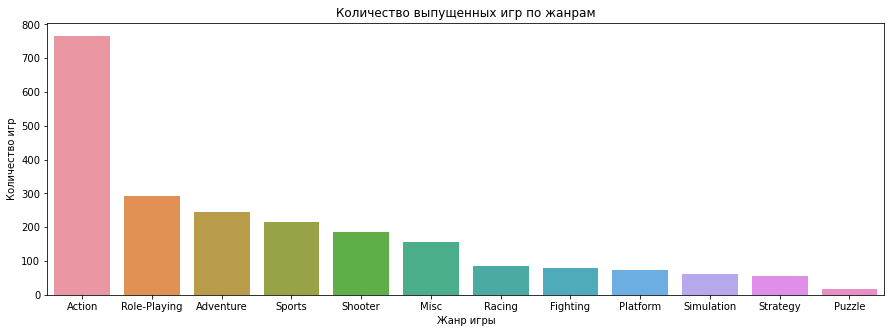

In [18]:
# Посмотрим на общее распределение игр по жанрам.
genre1 = df_actual.pivot_table(index='genre', values='total_sales', aggfunc='count').sort_values(
    by='total_sales', ascending=False)
genre2 = df_actual.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False)

# Количество выпущенных игр по жанрам
plt.figure(figsize=(15,5))
sns.barplot(data=genre1, x=genre1.index, y='total_sales')
plt.title('Количество выпущенных игр по жанрам')
plt.xlabel('Жанр игры')
plt.ylabel('Количество игр')
plt.show()

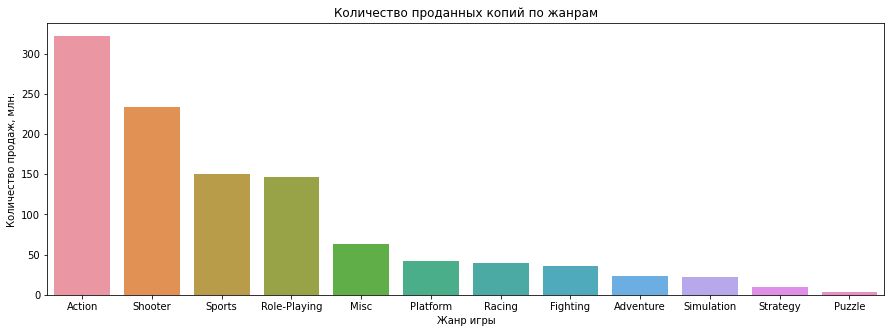

In [19]:
# Количество проданных копий
plt.figure(figsize=(15,5))
sns.barplot(data=genre2, x=genre2.index, y='total_sales')
plt.title('Количество проданных копий по жанрам')
plt.xlabel('Жанр игры')
plt.ylabel('Количество продаж, млн.')
plt.show()

Жанры с высокими продажами - Action, Shooter, Sports и Role-Playig.<br>Жанры с низкими продажами - Platform, Racing, Fighting, Adventure, Simulation, Strategy, Puzzle.<br>И я бы выделил Misc как переходный между высокими и низкими продажами. (Misc или Miscellaneous -  с английского "смешанный". То есть это игры в которых присутствую элемены нескольких жанров и основной жанр не определен.)<p>
Action и Role-Playig в топе благодаря тому, что много игр этого жанра выпускается в принципе. Sports и в особенности Shooter в топе потому, что это самые популярные жанры у игроков. Выпускается таких игр меньше чем Role-Playig, но продаж больше. Очень интересным выглядит жанр Adventure - он в топе по выпущеным играм, но один из аутсайдеров по продажам.

    


##  Портрет пользователя каждого региона.

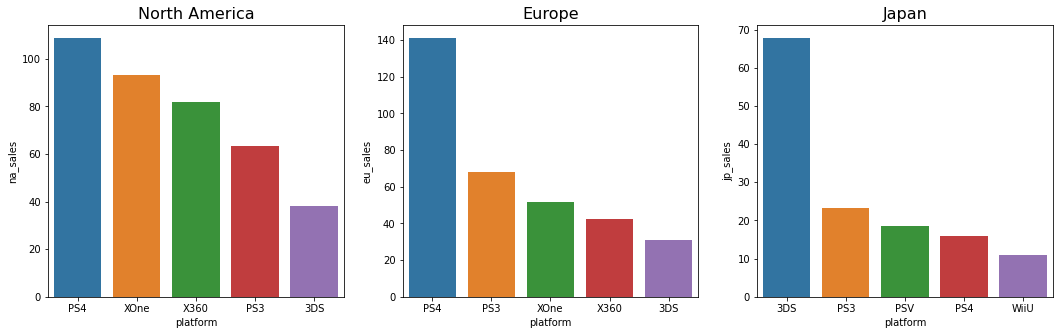

In [20]:
# Самые популярные платформы (топ-5) по регионам
#NA
na = df_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales', ascending=False).head()
#EU
eu = df_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales', ascending=False).head()
#JP
jp = df_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales', ascending=False).head()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.barplot(data=na, x=na.index, y='na_sales', ax=ax1)
sns.barplot(data=eu, x=eu.index, y='eu_sales', ax=ax2)
sns.barplot(data=jp, x=jp.index, y='jp_sales', ax=ax3)
ax1.set_title("North America", fontsize=16)
ax2.set_title("Europe", fontsize=16)
ax3.set_title("Japan", fontsize=16)
plt.show()

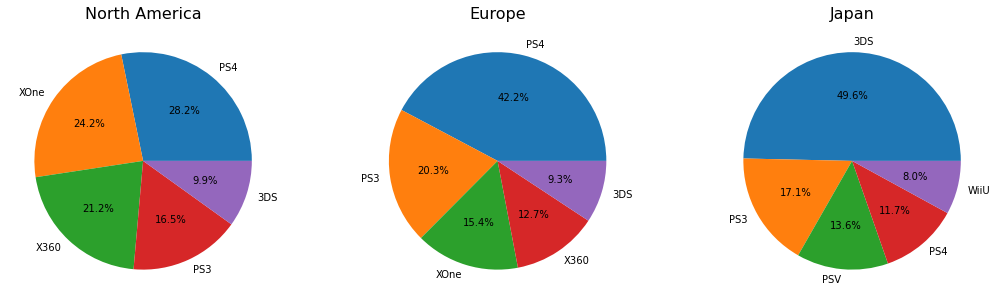

In [21]:
# Доли продаж платформ (топ-5) по регионам
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.pie(na['na_sales'], labels=na.index, autopct='%1.1f%%')
ax2.pie(eu['eu_sales'], labels=eu.index, autopct='%1.1f%%')
ax3.pie(jp['jp_sales'], labels=jp.index, autopct='%1.1f%%')
ax1.set_title("North America", fontsize=16)
ax2.set_title("Europe", fontsize=16)
ax3.set_title("Japan", fontsize=16)
plt.show()

В Северной Америке идет плотная конкуренция между PlayStation и Xbox: PS4 (28.2%) и PS3 (16.5%) занимают первую и четвертую строчки, а XOne (24.2%) и X360 (21.2%) вторую и третью соответственно. Nintendo 3DS (9.9%) замыкает пятерку.<p>
В Европе с огромным отрывом лидируют PS4 (42.2%) и PS3 (20.3%), следом идут XOne (15.4%) и X360 (12.7%). Ну и замыкает 3DS (9.3%).<p>
В Японии самыми популярными консолями являются "отечественные" - на первом месте с большим отрывом 3DS (49.6%). Дальше расположились консоли от Sony - PS3 (17.1%),PSV (13.6%),PS4 (11.7%) и замыкает топ WiiU (8.0%).

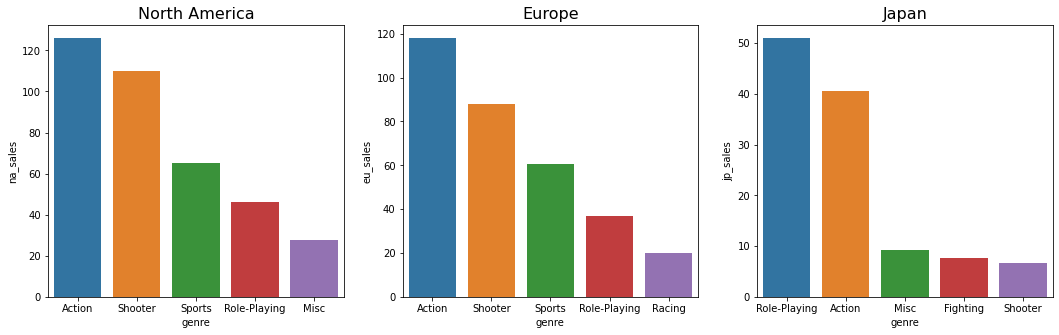

In [22]:
# Самые популярные жанры (топ-5) по регионам
#NA
na = df_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales', ascending=False).head()
#EU
eu = df_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales', ascending=False).head()
#JP
jp = df_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales', ascending=False).head()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.barplot(data=na, x=na.index, y='na_sales', ax=ax1)
sns.barplot(data=eu, x=eu.index, y='eu_sales', ax=ax2)
sns.barplot(data=jp, x=jp.index, y='jp_sales', ax=ax3)
ax1.set_title("North America", fontsize=16)
ax2.set_title("Europe", fontsize=16)
ax3.set_title("Japan", fontsize=16)
plt.show()

В Северной Америке и Европе самые популярные жанры практически совпадают, это Action, Shooter, Sports, Role-Playing. Отличаются только последние места: в Северной Америке Misc, в Европе Racing.<p>
В Японии предпочтения пользователей кардинально отличаются от Северной Америки и Европы - на первое место выходит Role-Playing. В топе не числится жанр Sports, но появляется жанр Fighting.

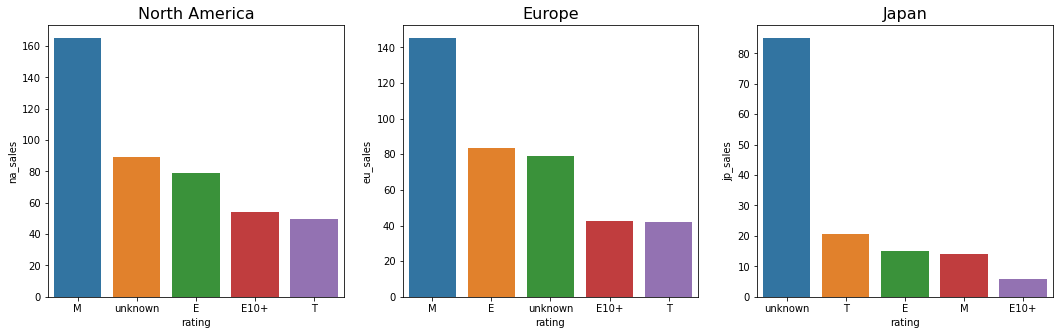

In [23]:
# Посмотрим влияет ли рейтинг ESRB на продажи в отдельном регионе
#NA
na = df_actual.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales', ascending=False).head()
#EU
eu = df_actual.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales', ascending=False).head()
#JP
jp = df_actual.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales', ascending=False).head()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.barplot(data=na, x=na.index, y='na_sales', ax=ax1)
sns.barplot(data=eu, x=eu.index, y='eu_sales', ax=ax2)
sns.barplot(data=jp, x=jp.index, y='jp_sales', ax=ax3)
ax1.set_title("North America", fontsize=16)
ax2.set_title("Europe", fontsize=16)
ax3.set_title("Japan", fontsize=16)
plt.show()

В Северной Америке и Европе продажи игр по возрастным рейтингам можно сказать идентичны. На первом месте игры "Для взрослых", вторую с третьей строчки делят "Для всех" и "Unknown", на четвертой строчке "Для всех от 10 лет и старше" и замыкает «Подросткам».
В Японии лидируют  c большим отрывом игры с неопределенным рейтингом "Unknown", далее идут "Подросткам", "Для всех" и "Для взрослых" и замыкают "Для всех от 10 лет и старше".<br/><br/>
Рейтинг "Unknown" можно предположить, все же не такой уж и неопределенный. В нашем исследовании учавствует рейтинг Entertainment Software Rating Board (ESRB) - его влияние распространяется в первую очередь на Северную Америку (США и Канада). В Европе же регулирующий в этой сфере орган Pan European Game Information (PEGI). А в Японии - Computer Entertainment Rating Organization (CERO).<br/>
Так без определения возрастного рейтинга игра в принципе не сможет продаваться в магазинах. Поэтому наши "Unknown" - это игры европейского и японского производства, которые получили свой возрастной рейтинг у своего регионального регулятора. На это нам сильно намекает первая позиция на японском рынке.<br/><br/>
Я склоняюсь к такому варианту, что если бы в исследование добавили помимо рейтинга ESRB - PEGI и CERO, то распределение продаж по возрастным рейтингам не изменилась бы (столбцы Unknown перетекли бы равномерно в другие имеющиеся).

## Проверим гипотезы.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H0 - Средние пользовательские рейтинги Xbox One равны средним пользовательским рейтингам PC.

H1 - Средние пользовательские рейтинги Xbox One и PC различаются.

In [24]:
# Выделим рейтинги пользователей нужных нам платформ
xone = df_actual.query('platform == "XOne"')['user_score'].dropna()
pc = df_actual.query('platform == "PC"')['user_score'].dropna()

# Посмотрим на дисперсию выборок
print('Дисперсия Xbox One:', np.var(xone))
print('Дисперсия PC:',np.var(pc))

Дисперсия Xbox One: 1.8965188383045533
Дисперсия PC: 3.0163063475546332


In [25]:
# Проведем статистический тест и проверим гипотезу
alpha = 0.05

results = st.ttest_ind(
    xone, 
    pc, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


In [26]:
# Посчитаем средние оценки для XOne и PC
print('Средний пользовательский рейтинг Xbox One:', round(xone.mean(), 2))
print('Средний пользовательский рейтинг PC:', round(pc.mean(), 2))

Средний пользовательский рейтинг Xbox One: 6.52
Средний пользовательский рейтинг PC: 6.27


Данный статистический тест не дал возможности опровергунть исходную гипотезу о том, что средние пользовательские рейтинги XOne и РС равны. Судя по расчетам средний пользовательский рейтинг этих двух платформ различается на 0.25 балла, что в рамках 10-ти бальной рейтинговой системы несущественно. Поэтому можно с уверенностью сказать, что средние пользовательские рейтинги Xbox One и PC практически не отличаются.

### Средние пользовательские рейтинги жанров Action и Sports разные.

H0 - Средние пользовательские рейтинги жанра Action равны средним пользовательским рейтингам жанра Sports.

H1 - Средние пользовательские рейтинги жанров Action и Sports различаются.

In [27]:
# Выделим рейтинги пользователей нужных нам жанров
action = df_actual.query('genre == "Action"')['user_score'].dropna()
sports = df_actual.query('genre == "Sports"')['user_score'].dropna()

# Посмотрим на дисперсию выборок
print('Дисперсия Action:', np.var(action))
print('Дисперсия Sports:',np.var(sports))

Дисперсия Action: 1.764812418633236
Дисперсия Sports: 3.1607339843749975


In [28]:
# Проведем статистический тест и проверим гипотезу
alpha = 0.05

results = st.ttest_ind(
    action, 
    sports, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


А значит сформулированная нами альтернативная гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports различаются, не отвергается!

In [29]:
# Посчитаем средние оценки для Action и Sports
print('Средний пользовательский рейтинг Action:', round(action.mean(), 2))
print('Средний пользовательский рейтинг Sports:', round(sports.mean(), 2))

Средний пользовательский рейтинг Action: 6.84
Средний пользовательский рейтинг Sports: 5.24


Наглядно видно, что средние пользовательские рейтинги Action и Sports отличаются на 1.6 балла. Это значение уже существенное для 10-ти бальной системы и в особенности для средних значений.<br/>
Исходя из результатов проверки гипотезы, верно утверждение, что cредние пользовательские рейтинги жанров Action и Sports различаются.

## Общий вывод.

В данном исследовании мы изучили исторические данные по рынку видео игр.
* <b>Мы определили основыне этапы роста и спада рынка:</b><br/>
    - C 1980 по 1993г - происходит зарождение рынка. Появляются первые игровые автоматы, позже первые портитивные приставки и консоли.<br/>
    - С 1994 по 2008г - начинается бурный рост индустрии с развитием програмного и аппаратного обеспечений, а так же интернета.<br/>
    - С 2009 по 2013г - на рынке намечается спад, так как появляется параллельный более перспективный рынок мобильного гейминга.<br/>
    - С 2013 по 2016г - можно наблюдать небольшой спад, но он уже не носит критичный характер.<br/>
* <b>Выделили самые успешные платформы за все время:</b><br/>
    - PS2, X360, PS3, Wii, DS и PS.<br/>
    - Определили, что средний срок жизни платформы - 10 лет.<br/>
* <b>Узнали на каких платформах лучше продаются игры:</b><br/>
    - Самые лучшие медианные продажи у гигантов рынка - PlayStation, Xbox и Wii.<br/>
    - Cудя по выбросам у платформ, ставку можно делать на известные и прибыльные франшизы.<br/>
* <b>Определили связь между продажами и отзывами критиков и пользователей:</b><br/>
    - Перед покупкой люди прислушиваются в той или иной степени к мнению критиков и это относится ко всем платформам.<br/>
    - К мнению пользователей прислушиваются только в Японии. Возможно это часть менталитета.<br/>
* <b>Узнали жанры с самыми высокими продажами и низкими продажами:</b><br/>
    - Жанры с высокими продажами - Action, Shooter, Sports и Role-Playig.<br/>
    - Жанр Misc как переходный между высокими и низкими продажами.<br/>
    - Жанры с низкими продажами - Platform, Racing, Fighting, Adventure, Simulation, Strategy, Puzzle.<br/>
* <b>Составили портреты пользователя для каждого региона:</b><br/>
    - В Северной Америке предпочитают PlayStation и Xbox, как правило играют в Action, Shooter, Sports, Role-Playing с возрастными рейтингами "Для взрослых" и "Для всех".<br/>
    - В Европе PlayStation и в меньшей степени Xbox, как правило играют в Action, Shooter, Sports, Role-Playing с возрастными рейтингами "Для взрослых" и "Для всех".<br/>
    - В Японии предпочитают "отечественные" консоли Nintendo 3DS/WiiU и Sony PSV/PS3/PS4 и играют как правило в Role-Playing и Action с возрастными рейтингами «Подросткам», "Для всех" и "Для взрослых".
<br/><br/>

<b>Для планирования рекламных кампаний на 2017 год:</b><br/>
Рекламные компании нужно разделить по регионам из-за специфики рынка.<br/>
Самая популярная линейка консолей во всем мире Sony PlayStation, поэтому к играм этих консолей больше всего будет привлечено внимания. В Северной Америке и в Европе так же стоит делать упор на игры выходящие на семействе Xbox. В Японии же в первую очередь нужно делать упор на семейство Nintendo, не забывая про Sony PlayStation, а вот Xbox в Япониии крайне не популярен и рекламировать игры на Xbox как деньги на ветер.<br/>
По поводу самих игр: идеальный вариант во всех регионах - игры жанра Action. В Северной Америке и Европе стоит так же делать упор на Shooter, Sports, Role-Playing. В Японии упор должен идти на Role-Playing и довольно популярным является Fighting, а вот жанр Sports не нашел широкого распространения.<br/>
Нужно прислушиваться к мнению критиков, они все же знают толк в играх.
Ну и конечно же нужно делать ставку на игры с высокими ожиданиями и высокими рейтингами критиков. Присматриваться к популярным франшизам и зарекомендованным за долгое время игровым студиям.